In [2]:
!git clone https://github.com/SocratesNFR/EvoDynamic.git

Cloning into 'EvoDynamic'...
remote: Enumerating objects: 898, done.
remote: Counting objects: 100% (464/464), done.
remote: Compressing objects: 100% (297/297), done.
remote: Total 898 (delta 339), reused 278 (delta 163), pack-reused 434
Receiving objects: 100% (898/898), 801.27 KiB | 4.35 MiB/s, done.
Resolving deltas: 100% (633/633), done.


In [6]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import networkx as nx
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

#from project1.lib.module import function
from EvoDynamic.evodynamic import experiment as experiment
from EvoDynamic.evodynamic.connection import random as conn_random
from EvoDynamic.evodynamic.connection import custom as conn_custom
from EvoDynamic.evodynamic import connection as connection
from EvoDynamic.evodynamic.cells import activation as act

In [32]:
from google.colab import files
uploaded = files.upload()

if (len(uploaded.keys()) > 1):
  print("Only one file allowed")
else:
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
    path_to_matrix = fn

Saving G4TEmatrix22.txt to G4TEmatrix22.txt
User uploaded file "G4TEmatrix22.txt" with length 29384 bytes


In [38]:
# Parameters

# Leaky integrate and fire
threshold = 1.0
potential_decay = 0.01

"""
Part 1 
Custom Matrix

"""
print(path_to_matrix)
conn_matrix = np.loadtxt(path_to_matrix, delimiter=",")
print(f"Importing matrix of size {conn_matrix.shape[0]}x{conn_matrix.shape[1]}")
# width = 100
width = conn_matrix.shape[0]# ** 2 # assumes matrix is square
input_size = width // 8



exp = experiment.Experiment()

# input layer
input_esn = exp.add_input(tf.float64, [input_size], "input_esn")

#
g_esn = exp.add_group_cells(name="g_esn", amount=width)
g_esn_real = g_esn.add_real_state(state_name='g_esn_bin')

g_esn_real_conn = conn_custom.create_custom_matrix('g_ca_bin_conn',conn_matrix)



"""
Part 2 
ESM

"""

g_esn_mem = g_esn.add_real_state(state_name='g_esn_mem')
g_esn_spike = g_esn.add_binary_state(state_name='g_esn_spike', init ='zeros')
g_esn_conn = conn_random.create_gaussian_matrix('g_esn_conn',width, sparsity=0.95, is_sparse=True)
g_esn_input_conn = conn_random.create_uniform_connection('g_esn_input_conn', input_size, width, sparsity=0.9)


exp.add_connection("input_conn", connection.WeightedConnection(input_esn,
                                                              g_esn_spike, act.integrate_and_fire,
                                                              g_esn_input_conn,
                                                              fargs_list=[(g_esn_mem,threshold,potential_decay)]))

exp.add_connection("g_esn_conn",
                   connection.WeightedConnection(g_esn_spike,
                                                 g_esn_spike, act.integrate_and_fire,
                                                 g_esn_conn,
                                                 fargs_list=[(g_esn_mem,threshold,potential_decay)]))

exp.initialize_cells()

G4TEmatrix22.txt
Importing matrix of size 64x64


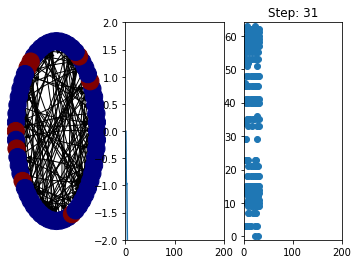

In [39]:
weight_matrix = exp.session.run(exp.get_connection("g_esn_conn").w)

G = nx.DiGraph()
G.add_edges_from(weight_matrix[0])

pos_fixed = nx.circular_layout(G)

# Animation
%matplotlib inline
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, axs = plt.subplots(nrows=1, ncols=3)

plt.title('Step: 0')
current_mem = exp.get_group_cells_state("g_esn", "g_esn_mem")[:,0]
current_spike = exp.get_group_cells_state("g_esn", "g_esn_spike")[:,0]

node_color = [round(current_spike[node],2) for node in G]

nx.draw(G.reverse(), node_color = node_color, pos=pos_fixed, cmap=plt.cm.jet,
        connectionstyle="arc3, rad=0.1", ax=axs[0])

idx_plot_neuron = 50
plot_width = 200
x_values = np.array([0])
mem_values = np.array([round(current_mem[idx_plot_neuron],2)])
spike_values, = np.where(current_spike == 1)
scatter_values = np.full_like(spike_values, 0)
axs_1, = axs[1].plot(x_values, mem_values)
axs_2 = axs[2].scatter(scatter_values, spike_values)

xmin, xmax = np.min(x_values), np.min(x_values)+plot_width
ymin, ymax = -2.0, 2.0
axs[1].set(xlim=(xmin, xmax), ylim=(ymin, ymax))
axs[2].set(xlim=(xmin, xmax), ylim=(-1, width))

idx_anim = 0

def updatefig(*args):
  global idx_anim, x_values, mem_values, spike_values, scatter_values#, axs_1, axs_2

  axs[0].clear()

  exp.run_step(feed_dict={input_esn: np.random.randint(2, size=(input_size,1))})

  current_mem = exp.get_group_cells_state("g_esn", "g_esn_mem")[:,0]
  current_spike = exp.get_group_cells_state("g_esn", "g_esn_spike")[:,0]


  current_spike_values = np.where(current_spike == 1)[0]
  current_scatter_values = np.full_like(current_spike_values, idx_anim+1)
  if idx_anim >= plot_width:
    x_values = np.concatenate((x_values[1:], [np.max(x_values)+1]))
    mem_values = np.concatenate((mem_values[1:], [current_mem[idx_plot_neuron]]))
    spike_values =  np.concatenate((spike_values[scatter_values>(idx_anim-plot_width)], current_spike_values))
    scatter_values = np.concatenate((scatter_values[scatter_values>(idx_anim-plot_width)], current_scatter_values))
  else:
    x_values = np.concatenate((x_values, [np.max(x_values)+1]))
    mem_values = np.concatenate((mem_values, [current_mem[idx_plot_neuron]]))
    spike_values =  np.concatenate((spike_values, np.where(current_spike == 1)[0]))
    scatter_values = np.concatenate((scatter_values, current_scatter_values))

  node_color = [round(current_spike[node],2) for node in G]
  nx.draw(G.reverse(), node_color = node_color, pos=pos_fixed, cmap=plt.cm.jet,
          connectionstyle="arc3, rad=0.1", ax=axs[0])

  xmin, xmax = np.min(x_values), np.min(x_values)+plot_width
  axs[1].set(xlim=(xmin, xmax))
  axs[2].set(xlim=(xmin, xmax))

  axs_1.set_data(x_values, mem_values)
  axs_2.set_offsets(np.vstack((scatter_values, spike_values)).transpose())

  plt.title('Step: '+str(idx_anim))
  idx_anim += 1


ani = animation.FuncAnimation(fig, updatefig, frames=30, interval=500, blit=False)

# plt.show()


HTML(ani.to_html5_video())

# plt.connect('close_event', exp.close())